这是lecture的第一节课，讲的主要是自动求导的过程，说真的，这门课确实让我对反向传播的实现更为理解了，以前只是知道反向传播的原理，这次是实实在在的知道了反向传播的实现原理！

反向传播——将导数从loss向输入不断传递！
在这里不是一步到位的，这主要是利用的链式求导法则，通过用局部的导数去获取当前的结点的导数！
在计算导数的时候，可以将一个复杂的整体拆分成一个有一个原子，这样在计算导数的时候就会很简单，这样就只需要定义乘法和加法的方向传播了，会简化计算，当然也可以一步到位，通过公式法直接获得导数（不推荐）

在这节课上，我对class的用法更为熟悉了，说真的python我并没有学的很深，有必要去花时间补充python的知识了！

乘法：out.grad * other.data
加法:out.grad * 1.0

核心core：通过out.grad和self.data以及other.data来求导数; 原子拆分！
         loss反向传播的过程就是不断调用backward的过程，通过从后往前遍历所有的结点，对于每个节点调用backword函数，因此可以采用拓扑排序来获取结点序列！然后reserve该序列便可以获得调用顺序！！

心得：通过个例以及简单的例子去获取规律，然后在进行抽象化，最终就可以获得答案了，当然最重要的就是明白流程！！！

In [82]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [116]:
#定义一个类value用来保存每个结点的信息
class Value:
    def __init__(self,data, _children=(), _op='',label=''):
        self.label = label
        #forward process
        self.data = data
        self._op = _op
        self._prev = set(_children)  #the previous node
        # grid computation
        self.grad = 0.0
        self._backward = lambda: None


    def __repr__(self):
        return f"Value(data={self.data})"  # the info of return value
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')  #the current node and the previous node
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out   #plus
    
    def __mul__(self,other): #multiply
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out  
    
    def __pow__(self,other): #power
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), '**')

        def _backward():
              self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
# use add and mutiply to implement other operations

    def __neg__(self):
        return self * -1
    
    def __sub__(self,other): #minus
        return self + (-other)
    
    def __truediv__(self,other): #divide
        return self * other ** -1
    
    def __radd__(self,other):
        return self + other  #reverse plus
    
    def __rmul__(self,other):
        return self * other
    
    def tanh(self): #tanh function
        x = self.data
        t = math.tanh(x) 
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self): #exponential function
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        #backward process
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()






In [52]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    #dot.node(name = uid, label = "{ | data %.4f |}" % ( n.data), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [53]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

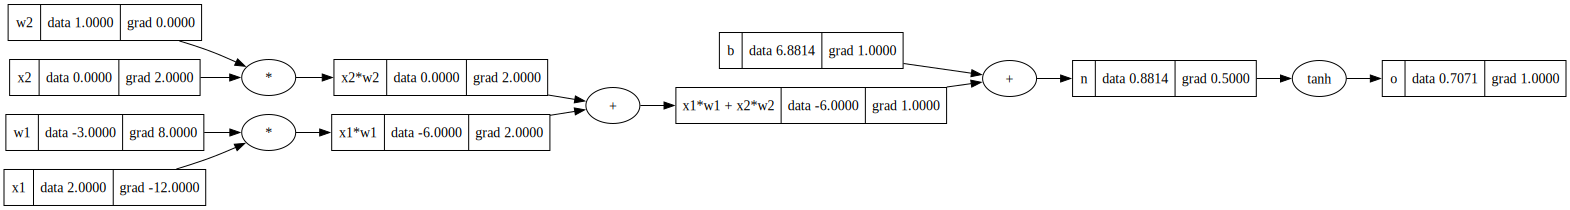

In [54]:
draw_dot(o) # draw the graph of the computation

In [47]:
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"


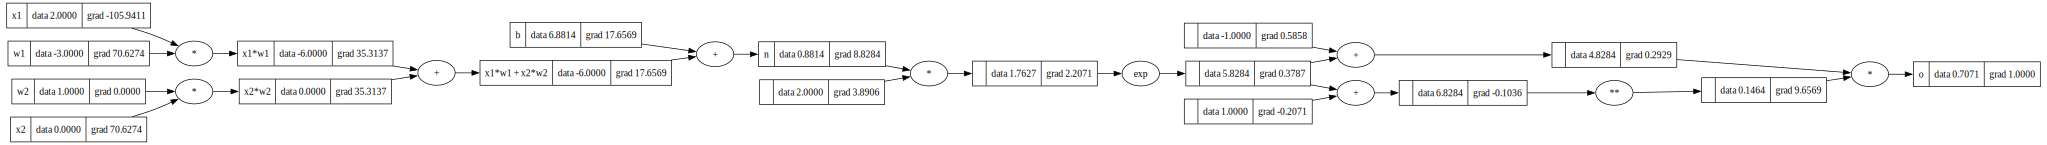

In [48]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [104]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # x is a list of inputs
        # w is a list of weights
        # b is a bias
        # return the output of the neuron
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        # x is a list of inputs
        # return the output of the layer
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        # x is a list of inputs
        # return the output of the MLP
        for l in self.layers:
            x = l(x)
        return x

    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]


In [117]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
n = MLP(3, [4, 4, 1]) # 3 inputs, 4 hidden neurons, 4 hidden neurons, 1 output neuron

In [118]:
for k in range(20):
    
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    for p in n.parameters():
        p.data += -0.1 * p.grad# gradient descent
    print(k, loss.data) # print the loss value

0 6.130383408088655
1 0.5038322327093102
2 0.11289263658521033
3 0.07710313733208818
4 0.058758140074178
5 0.04747879001517542
6 0.03981491393902886
7 0.03426092750792351
8 0.030048998538371757
9 0.02674480543447505
10 0.024083641391892927
11 0.021894772674139803
12 0.020063052811194287
13 0.018507967325941854
14 0.017171508766996024
15 0.016010819289841313
16 0.014993545415162183
17 0.014094804744349265
18 0.013295147087682362
19 0.012579149065292946


In [119]:
ypred

[Value(data=0.95187096923826),
 Value(data=-0.9466988003818047),
 Value(data=-0.9406463463494282),
 Value(data=0.9375590568551556)]